In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [5]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \delta\eta \log\tilde e \\
    & +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} (\eta - 1) \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + (\eta -1)(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2} (\eta - 1) \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}(\eta -1)\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [6]:
def simulate_jump(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y = np.mean(θ_list)*290
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [7]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    # ax3.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
    ax3.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

In [8]:
ξa = 1_000
ξw = 1/900
ξp = ξw
dmg_weight = np.array([0.5, 0.5, 0.])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args,)

episode: 10000,	 ode error: 1.5616581353193213e-06,	 ft error: 1.578169618575894e-06
episode: 3488,	 ode error: 2.271884423231136e-06,	 ft error: 9.999436521856975e-09
episode: 3861,	 ode error: 8.461161858095075e-06,	 ft error: 9.973757051732573e-09
episode: 862,	 ode error: 3.363054231857545e-06,	 ft error: 9.940737677460731e-09


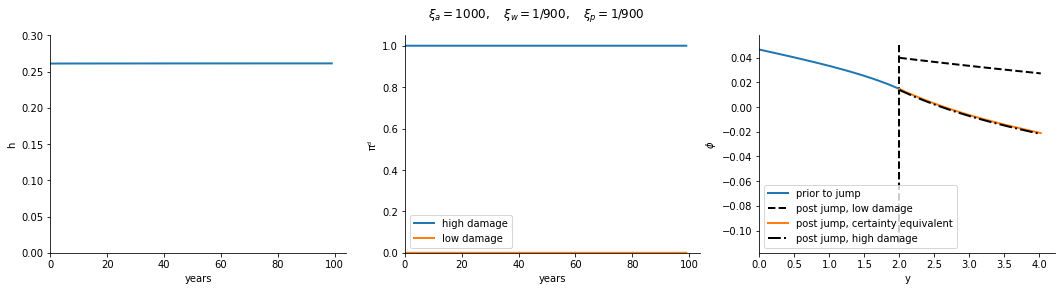

In [9]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
args_plot = (ξa, ξw, ξp, numy_bar)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

In [10]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = δ*(1-η)/((α - invkap)*np.exp(Kt))
    Ct = (α - invkap)*np.exp(Kt)
    SCCt = MEt/MCt*1000
    return SCCt, Ct

In [11]:
MEt = δ*η/et
SCCt, Ct = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)

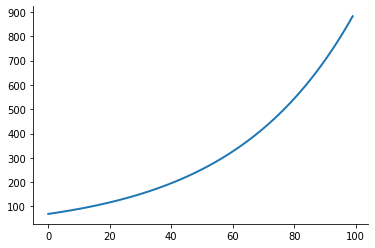

In [12]:
plt.plot(SCCt)

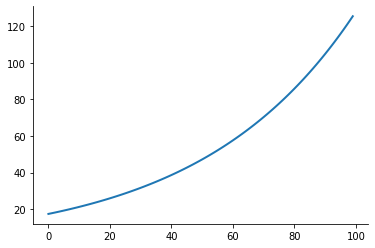

In [13]:
plt.plot(Ct)

In [14]:
np.log(Ct[0])

2.855970331178833

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + (\eta-1)\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\delta\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \delta\eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}(\eta -1)\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [15]:
# solve for decompose
def solve_baseline(y_grid, numy_bar, solu, ϕ_list, args, ϵ=0.3, tol=1e-8, max_iter=10_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy = args
    ems_star = solu['ems']
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dy = y_grid_cap[1] - y_grid_cap[0]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = -δ*np.ones(y_grid_cap.shape)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = δ*η*np.log(ems_star) + (η-1)*dΛ*ems_star*θ + (η-1)*ddΛ*ems_star**2*σy**2/2
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

    dϕdy = derivative_1d(ϕ, 1, dy)
    dϕdyy = derivative_1d(ϕ, 2, dy)

    error = np.max(abs(A*ϕ + B*dϕdy + C*dϕdyy + D))
    
    ME = -(dϕdy+(η-1)*dΛ)*θ - (dϕdyy+(η-1)*ddΛ)*σy**2*ems_star
    ratio = ME/(δ*η/ems_star)

    print("PDE error: %s" % (error))  
    return ME, ratio

In [16]:
ξa = 1/10_000
ξw = 1/600
ξp = 60*ξw
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_5_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_baseline(y_grid, numy_bar, solu, ϕ_5_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, em_t = simulate_jump(y_grid[:numy_bar+1], solu, ME, θ_list)

episode: 5000,	 ode error: 1.2556663083452234e-06,	 ft error: 1.6333888116596789e-06
episode: 3491,	 ode error: 2.559422536444595e-06,	 ft error: 9.97718671569281e-09
episode: 3859,	 ode error: 9.286483582182316e-06,	 ft error: 9.996133319238137e-09
episode: 842,	 ode error: 5.557508869081043e-06,	 ft error: 9.971355049524327e-09
episode: 951,	 ode error: 6.794948936703917e-06,	 ft error: 9.87185770628951e-09
PDE error: 5.405493172027677e-06


(0.0, 40.0)

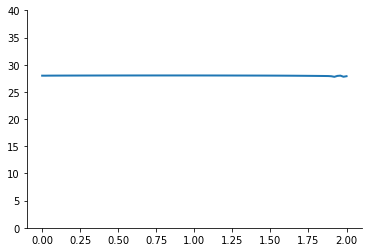

In [17]:
plt.plot(y_grid[:numy_bar+1],-100*np.log(ratio))
plt.ylim(0,40)

(0.0, 1.0)

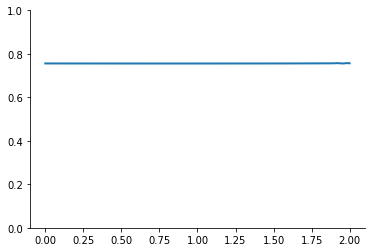

In [18]:
plt.plot(y_grid[:numy_bar+1],ratio)
plt.ylim(0,1)

In [19]:
ratio

array([0.75589153, 0.75590686, 0.75584856, 0.75582198, 0.75580547,
       0.75579236, 0.75578094, 0.75577006, 0.75575965, 0.75574961,
       0.75573991, 0.75573054, 0.75572149, 0.75571276, 0.75570434,
       0.75569624, 0.75568844, 0.75568094, 0.75567374, 0.75566684,
       0.75566024, 0.75565393, 0.75564791, 0.75564218, 0.75563673,
       0.75563158, 0.75562671, 0.75562212, 0.75561782, 0.75561381,
       0.75561008, 0.75560664, 0.75560349, 0.75560064, 0.75559808,
       0.75559582, 0.75559387, 0.75559223, 0.75559091, 0.75558992,
       0.75558926, 0.75558895, 0.75558899, 0.75558941, 0.75559021,
       0.75559141, 0.75559301, 0.75559505, 0.75559752, 0.75560045,
       0.75560385, 0.75560772, 0.75561208, 0.75561691, 0.75562223,
       0.75562802, 0.75563426, 0.75564094, 0.75564802, 0.75565546,
       0.75566323, 0.75567128, 0.75567956, 0.75568802, 0.75569663,
       0.75570535, 0.75571418, 0.75572312, 0.7557322 , 0.75574148,
       0.75575106, 0.75576106, 0.75577164, 0.75578297, 0.75579

In [20]:
yt, et, πᵈt, πᶜt, ιt, ht, em_t = simulate_jump(y_grid[:numy_bar+1], solu, ME, θ_list)

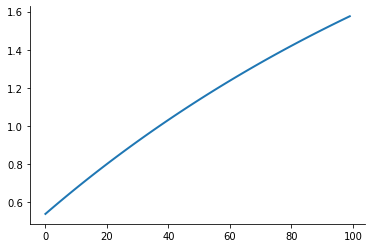

In [21]:
plt.plot(yt)

In [22]:
def plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, MEt):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [23]:
ξa = 1000
ξw = 1000
ξp = 1/20
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)

episode: 5000,	 ode error: 3.4635895971560273e-06,	 ft error: 2.2128578556351863e-06
episode: 3433,	 ode error: 3.274476076540599e-06,	 ft error: 9.988420495802657e-09
episode: 3839,	 ode error: 1.167919328730071e-05,	 ft error: 9.976416637247354e-09
episode: 932,	 ode error: 7.742935647732775e-06,	 ft error: 9.904765965740303e-09


In [24]:
_, et_base, _, _, _, _ = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

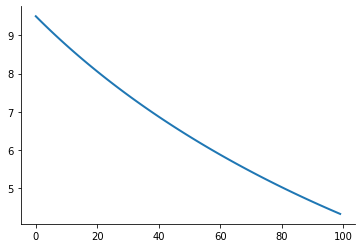

In [25]:
plt.plot(et_base[et_base>0])

In [26]:
def simulate_jump_ems(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y = np.mean(θ_list)*290
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@πᶜ_list + σy*h_point)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [27]:
ξa = 1_000
ξw = 1000
ξp = 1000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_baseline(y_grid, numy_bar, solu, ϕ_list, args)
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], solu, ME, θ_list)

episode: 5000,	 ode error: 3.4635895971560273e-06,	 ft error: 2.2128578556351863e-06
episode: 3433,	 ode error: 3.274476076540599e-06,	 ft error: 9.988420495802657e-09
episode: 3839,	 ode error: 1.167919328730071e-05,	 ft error: 9.976416637247354e-09
episode: 747,	 ode error: 5.216995514610578e-06,	 ft error: 9.904244554122718e-09
episode: 742,	 ode error: 7.406881883694112e-06,	 ft error: 9.727176633611556e-09
PDE error: 5.216750509928726e-06


In [28]:
ξa = 1000
ξw = 1/600
ξp = 1/20
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_baseline(y_grid, numy_bar, solu, ϕ_list, args)
yt_browian, et_brownian, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], solu, ME, θ_list)

episode: 5000,	 ode error: 1.2255557584386076e-06,	 ft error: 1.4294773279197963e-06
episode: 3495,	 ode error: 2.481608791508232e-06,	 ft error: 9.980640492309364e-09
episode: 3854,	 ode error: 9.085891506471598e-06,	 ft error: 9.989838724762853e-09
episode: 1351,	 ode error: 1.0168782672690074e-05,	 ft error: 9.913291692161449e-09
episode: 948,	 ode error: 8.282813995242222e-06,	 ft error: 9.895657534138754e-09
PDE error: 5.254224385573545e-06


In [29]:
ξa = 1/10_000
ξw = 1000
ξp = 1/20
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_baseline(y_grid, numy_bar, solu, ϕ_list, args)

episode: 5000,	 ode error: 1.2262387482078405e-06,	 ft error: 2.711606050045945e-06
episode: 3461,	 ode error: 3.1670562094565148e-06,	 ft error: 9.973137130951198e-09
episode: 3849,	 ode error: 1.0981060913034852e-05,	 ft error: 9.992512604399078e-09
episode: 5000,	 ode error: 7.437542847499269e-06,	 ft error: 3.0296077046613563e-06
episode: 898,	 ode error: 5.055357634958498e-06,	 ft error: 9.870262685877467e-09
PDE error: 4.652813538524154e-06


In [30]:
yt_smooth, et_smooth, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], solu, ME, θ_list)

Text(0.5, 0, 'Years')

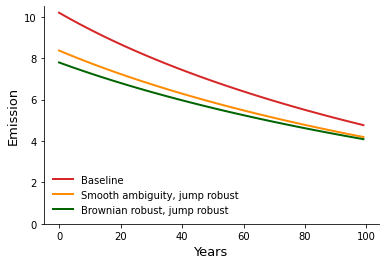

In [38]:
plt.plot(et_bb, label="Baseline", color="tab:red")
plt.plot(et_smooth, label="Smooth ambiguity, jump robust", color="darkorange")
plt.plot(et_brownian, label="Brownian robust, jump robust", color="darkgreen")
# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emission', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")

In [32]:
np.log(et_base)

array([2.25126575, 2.24279683, 2.23435607, 2.22594253, 2.21755529,
       2.20919347, 2.20085619, 2.19254262, 2.18425627, 2.17599317,
       2.16775135, 2.15953004, 2.1513285 , 2.14314794, 2.13498995,
       2.12684952, 2.11872599, 2.11061875, 2.10253159, 2.09446143,
       2.08640558, 2.07836348, 2.07033836, 2.06232865, 2.05433089,
       2.04634462, 2.03837478, 2.03041646, 2.02246801, 2.01453127,
       2.00660772, 1.99869253, 1.99078587, 1.98289264, 1.97500639,
       1.96712687, 1.95925963, 1.9513982 , 1.94354255, 1.93569748,
       1.92785701, 1.92002218, 1.91219543, 1.9043723 , 1.89655509,
       1.88874316, 1.88093406, 1.87313119, 1.86533091, 1.85753398,
       1.849741  , 1.84194956, 1.834162  , 1.82637577, 1.81859166,
       1.81080926, 1.80302777, 1.79524791, 1.78746835, 1.77968967,
       1.77191106, 1.7641326 , 1.75635385, 1.74857483, 1.74079497,
       1.73301464, 1.72523274, 1.71745036, 1.7096656 , 1.70188044,
       1.69409208, 1.68630343, 1.67851079, 1.67071795, 1.66292

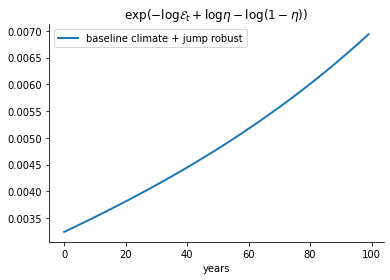

In [34]:
plt.plot( np.exp(-np.log(et_bb) + np.log(η) - np.log(1- η)), label="baseline climate + jump robust")
# plt.plot( np.exp(- np.log(et_dist) + np.log(η) - np.log(1 -η)), label="distorted + jump robust")
# plt.plot( np.exp(- np.log(et) + np.log(η) - np.log(1 -η)), label="with drift term + jump robust")
plt.legend()
# plt.ylim(0)
# plt.ylabel('emission')
plt.xlabel('years')
plt.title('$ \exp(-\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta))$')
plt.savefig("./paper_plots/logscc.pdf")

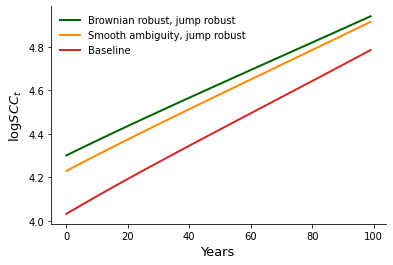

In [39]:
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="Brownian robust, jump robust", color="darkgreen")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="Smooth ambiguity, jump robust", color="darkorange")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="Baseline", color="tab:red")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.legend(frameon=False, fontsize=10)
# plt.ylim(0)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")

Text(0.5, 0, 'Years')

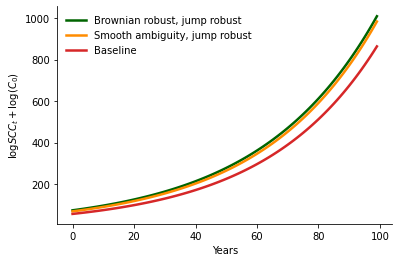

In [152]:
plt.plot( np.exp(np.log(1000) + np.log(Ct)  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η)), label="Brownian robust, jump robust", color="darkgreen")
plt.plot( np.exp(np.log(1000) + np.log(Ct)   - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η)), label="Smooth ambiguity, jump robust", color="darkorange")
plt.plot( np.exp(np.log(1000) + np.log(Ct)   - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η)), label="Baseline", color="tab:red")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.legend(frameon=False)
# plt.ylim(0)
plt.ylabel('$\log SCC_t + \log(C_0)$')
plt.xlabel('Years')
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")

In [65]:
np.log(η)

-3.4420193761824103

In [40]:
ξa = 1/10_000
ξw = 1000
ξp = 1/20
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_baseline(y_grid, numy_bar, solu, ϕ_list, args)
yt, et_dist, πᵈt, πᶜt, ιt, ht, me = simulate_jump_ems(y_grid[:numy_bar+1], solu, ME, θ_list)

episode: 5000,	 ode error: 1.2262387482078405e-06,	 ft error: 2.711606050045945e-06
episode: 3461,	 ode error: 3.1670562094565148e-06,	 ft error: 9.973137130951198e-09
episode: 3849,	 ode error: 1.0981060913034852e-05,	 ft error: 9.992512604399078e-09
episode: 5000,	 ode error: 7.437542847499269e-06,	 ft error: 3.0296077046613563e-06
episode: 898,	 ode error: 5.055357634958498e-06,	 ft error: 9.870262685877467e-09
PDE error: 4.652813538524154e-06


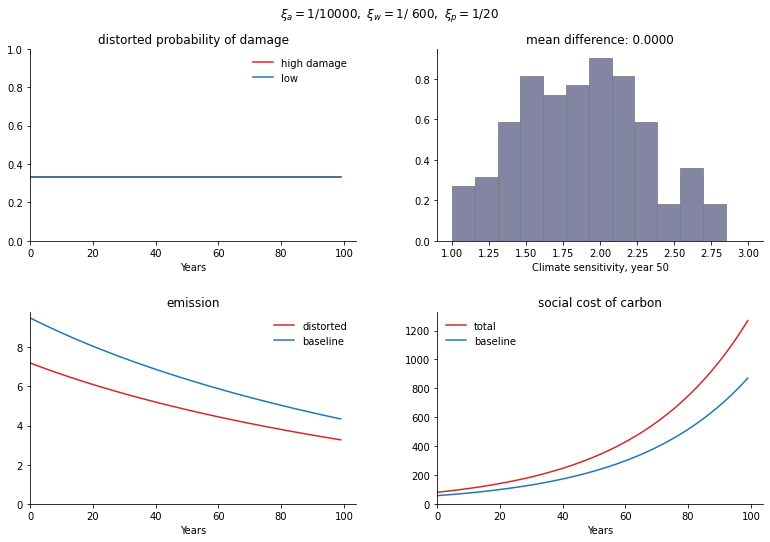

In [76]:
fig, ((ax1, ax2), (ax3, ax4)) = plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
fig.suptitle("$ξ_a = 1/10000,\ ξ_w = 1/\ 600,\ ξ_p =  1/20$")
# plt.savefig('15_600_1.pdf')
plt.show()

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = 30*ξ
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_30.pdf')
plt.show()

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = ξ
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_1.pdf')
plt.show()

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = 1000
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_1000.pdf')
plt.show()